Step 1: Pre-processing

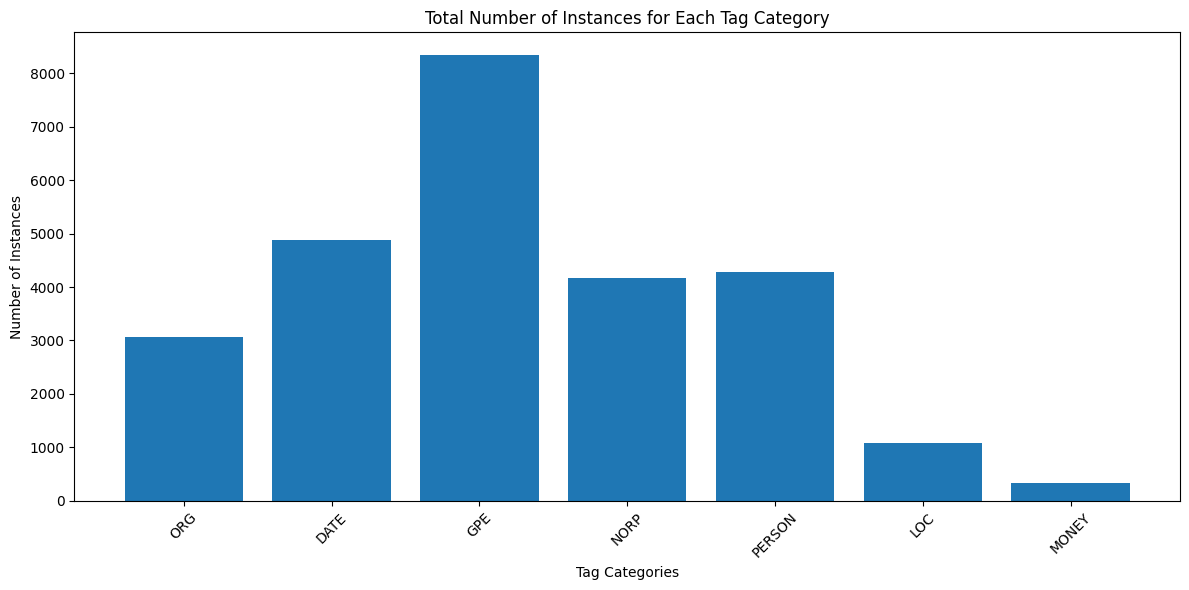


Tag Distribution Analysis:
--------------------------

PERSON:
Total instances: 4273
Tweets with at least one PERSON: 30.20%
Tweets with 2 or more PERSON: 6.69%

NORP:
Total instances: 4167
Tweets with at least one NORP: 28.64%
Tweets with 2 or more NORP: 7.15%

ORG:
Total instances: 3065
Tweets with at least one ORG: 23.02%
Tweets with 2 or more ORG: 4.04%

GPE:
Total instances: 8351
Tweets with at least one GPE: 49.86%
Tweets with 2 or more GPE: 17.93%

LOC:
Total instances: 1089
Tweets with at least one LOC: 8.63%
Tweets with 2 or more LOC: 1.06%

DATE:
Total instances: 4889
Tweets with at least one DATE: 37.35%
Tweets with 2 or more DATE: 5.86%

MONEY:
Total instances: 329
Tweets with at least one MONEY: 2.59%
Tweets with 2 or more MONEY: 0.36%


In [ ]:
import json
import matplotlib.pyplot as plt
from collections import Counter

# Read the JSON file
with open('/content/assignment5_data 1.json', 'r') as file:
    data = json.load(file)

# Initialize counters
tag_counts = Counter()
tweets_with_tag = {tag: 0 for tag in ['PERSON', 'NORP', 'ORG', 'GPE', 'LOC', 'DATE', 'MONEY']}
tweets_with_multiple_tags = {tag: 0 for tag in ['PERSON', 'NORP', 'ORG', 'GPE', 'LOC', 'DATE', 'MONEY']}

# Process each tweet
total_tweets = len(data['annotations'])
for tweet in data['annotations']:
    # Count tags in current tweet
    tweet_tags = Counter()

    for entity in tweet[1]['entities']:
        tag = entity[2]
        tag = tag.strip()
        tag_counts[tag] += 1
        tweet_tags[tag] += 1

    # Count tweets with at least one occurrence of each tag
    for tag in tweet_tags:
        tag = tag.strip()
        tweets_with_tag[tag] += 1
        if tweet_tags[tag] >= 2:
            tweets_with_multiple_tags[tag] += 1

# Create bar plot for total tag counts
plt.figure(figsize=(12, 6))
plt.bar(tag_counts.keys(), tag_counts.values())
plt.title('Total Number of Instances for Each Tag Category')
plt.xlabel('Tag Categories')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print statistics
print("\nTag Distribution Analysis:")
print("--------------------------")
for tag in tweets_with_tag:
    percent_with_tag = (tweets_with_tag[tag] / total_tweets) * 100
    percent_with_multiple = (tweets_with_multiple_tags[tag] / total_tweets) * 100

    print(f"\n{tag}:")
    print(f"Total instances: {tag_counts[tag]}")
    print(f"Tweets with at least one {tag}: {percent_with_tag:.2f}%")
    print(f"Tweets with 2 or more {tag}: {percent_with_multiple:.2f}%")

Step 2: Converting to IOB tags:

In [2]:
import json
from transformers import BertTokenizer

def convert_to_iob(document, annotations):
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    tokens = tokenizer.tokenize(document)

    # Create a list to hold the IOB tags
    iob_tags = ['O'] * len(tokens)

    # Create a set to keep track of the spans
    entity_spans = []
    for entity in annotations['entities']:
        start, end, label = entity
        entity_spans.append((start, end, label))

    # Assign IOB tags
    for start, end, label in entity_spans:
        # Find the start and end tokens
        # Use len() instead of size() to get the length of the encoded tokens
        start_token_index = len(tokenizer.encode(document[:start], add_special_tokens=False))
        end_token_index = len(tokenizer.encode(document[:end], add_special_tokens=False)) - 1

        if start_token_index < len(iob_tags):
            iob_tags[start_token_index] = f'B-{label}'

        for i in range(start_token_index + 1, min(end_token_index + 1, len(iob_tags))):
            iob_tags[i] = f'I-{label}'

    # Add special tokens [CLS] and [SEP]
    iob_tags = ['O'] + iob_tags + ['O']

    return iob_tags

# Example usage
with open('/content/assignment5_data 1.json') as f:
    data = json.load(f)

iob_results = []
for item in data['annotations']:
    document = item[0]
    annotations = item[1]
    iob_tags = convert_to_iob(document, annotations)
    iob_results.append((document, iob_tags))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Step 3: Finetuning BERT - Training a sequence labeling model:

In [3]:
import json
from transformers import BertTokenizer
import pandas as pd  # Import pandas
from sklearn.model_selection import train_test_split

# Prepare the data for training
documents = [doc for doc, _ in iob_results]
iob_labels = [tags for _, tags in iob_results]

# Split into training and test sets
train_docs, test_docs, train_labels, test_labels = train_test_split(
    documents, iob_labels, test_size=0.2, random_state=21
)

# Further split the training set into training and validation sets
train_docs, val_docs, train_labels, val_labels = train_test_split(
    train_docs, train_labels, test_size=0.2, random_state=21
)

In [4]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
from tqdm import tqdm

# Define constants
BERT_MODEL_NAME = "bert-base-cased"  # Changed back to BERT-base-cased
EPOCHS = 30
BATCH_SIZE = 64  # Adjusted for BERT-base-cased memory requirements
LEARNING_RATE = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ACCUMULATION_STEPS = 2
EARLY_STOPPING_PATIENCE = 3
MAX_LEN = 128

# Initialize tag mappings
unique_tags = set([tag for doc_labels in train_labels for tag in doc_labels])
NUM_CLASSES = len(unique_tags) + 1
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}
tag2id['[PAD]'] = NUM_CLASSES - 1
id2tag[NUM_CLASSES - 1] = '[PAD]'

class SequenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len, tag2id):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.tag2id = tag2id

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
        )

        label_ids = [-100] * self.max_len
        for i, tag in enumerate(labels[: self.max_len - 2]):
            label_ids[i + 1] = self.tag2id.get(tag, -100)

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label_ids, dtype=torch.long),
        }

class BertForSequenceLabeling(nn.Module):
    def __init__(self, num_classes):
        super(BertForSequenceLabeling, self).__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(
            input_ids=input_ids, attention_mask=attention_mask, return_dict=True
        )
        sequence_output = self.dropout(outputs.last_hidden_state)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fn(logits.view(-1, NUM_CLASSES), labels.view(-1))

        return logits, loss

def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(EPOCHS):
        # Training
        model.train()
        total_loss = 0
        optimizer.zero_grad()

        train_iterator = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for step, batch in enumerate(train_iterator):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            logits, loss = model(input_ids, attention_mask, labels)

            # Normalize loss for gradient accumulation
            loss = loss / ACCUMULATION_STEPS
            loss.backward()

            if (step + 1) % ACCUMULATION_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Added gradient clipping
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            total_loss += loss.item() * ACCUMULATION_STEPS
            train_iterator.set_postfix({'loss': f'{total_loss/(step+1):.4f}'})

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch["input_ids"].to(DEVICE)
                attention_mask = batch["attention_mask"].to(DEVICE)
                labels = batch["labels"].to(DEVICE)

                _, loss = model(input_ids, attention_mask, labels)
                val_loss += loss.item()

        val_loss = val_loss / len(val_dataloader)
        print(f"Epoch {epoch+1}/{EPOCHS}, Training Loss: {total_loss/len(train_dataloader):.4f}, Validation Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping triggered after epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break

    return model

# Prepare the data
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

train_dataset = SequenceDataset(train_docs, train_labels, tokenizer, MAX_LEN, tag2id)
val_dataset = SequenceDataset(val_docs, val_labels, tokenizer, MAX_LEN, tag2id)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True  # Added pin_memory for faster data transfer to GPU
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True
)

# Initialize model and optimizer
model = BertForSequenceLabeling(NUM_CLASSES).to(DEVICE)

# Initialize optimizer with weight decay
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=0.01  # Added weight decay for better regularization
)

# Setup learning rate scheduler
num_training_steps = len(train_dataloader) * EPOCHS // ACCUMULATION_STEPS
num_warmup_steps = num_training_steps // 10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Train the model
print("Starting training...")
model = train_model(model, train_dataloader, val_dataloader, optimizer, scheduler)

# Evaluation
print("\nEvaluating...")
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in tqdm(val_dataloader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        logits, _ = model(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=2)

        active_labels = labels.view(-1) != -100
        active_preds = preds.view(-1)[active_labels]
        active_labels = labels.view(-1)[active_labels]

        all_labels.extend(active_labels.cpu().numpy())
        all_preds.extend(active_preds.cpu().numpy())

# Calculate metrics
unique_labels_in_preds = set(all_preds)
unique_labels_in_ground_truth = set(all_labels)
all_unique_labels = unique_labels_in_preds.union(unique_labels_in_ground_truth)
target_names = [id2tag[label_id] for label_id in sorted(list(all_unique_labels))]

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training...


Epoch 1/30: 100%|██████████| 111/111 [02:13<00:00,  1.20s/it, loss=2.4885]


Epoch 1/30, Training Loss: 2.4885, Validation Loss: 1.1440


Epoch 2/30: 100%|██████████| 111/111 [02:21<00:00,  1.27s/it, loss=0.7885]


Epoch 2/30, Training Loss: 0.7885, Validation Loss: 0.4360


Epoch 3/30: 100%|██████████| 111/111 [02:21<00:00,  1.28s/it, loss=0.3405]


Epoch 3/30, Training Loss: 0.3405, Validation Loss: 0.2543


Epoch 4/30: 100%|██████████| 111/111 [02:21<00:00,  1.28s/it, loss=0.2404]


Epoch 4/30, Training Loss: 0.2404, Validation Loss: 0.2311


Epoch 5/30: 100%|██████████| 111/111 [02:21<00:00,  1.28s/it, loss=0.2116]


Epoch 5/30, Training Loss: 0.2116, Validation Loss: 0.2272


Epoch 6/30: 100%|██████████| 111/111 [02:21<00:00,  1.28s/it, loss=0.1942]


Epoch 6/30, Training Loss: 0.1942, Validation Loss: 0.2262


Epoch 7/30: 100%|██████████| 111/111 [02:21<00:00,  1.28s/it, loss=0.1798]


Epoch 7/30, Training Loss: 0.1798, Validation Loss: 0.2315


Epoch 8/30: 100%|██████████| 111/111 [02:21<00:00,  1.28s/it, loss=0.1655]


Epoch 8/30, Training Loss: 0.1655, Validation Loss: 0.2335


Epoch 9/30: 100%|██████████| 111/111 [02:22<00:00,  1.28s/it, loss=0.1532]


Epoch 9/30, Training Loss: 0.1532, Validation Loss: 0.2479
Early stopping triggered after epoch 9

Evaluating...


Evaluating: 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Classification Report:
              precision    recall  f1-score   support

      I-NORP       0.63      0.51      0.56       302
      B-DATE       0.78      0.87      0.82       764
     B-MONEY       0.90      0.78      0.83        45
   B-PERSON        0.00      0.00      0.00        23
       I-GPE       0.69      0.78      0.74       970
     I-NORP        0.00      0.00      0.00         9
      B-NORP       0.74      0.81      0.77       645
   I-PERSON        0.00      0.00      0.00        49
       B-LOC       0.58      0.32      0.42       191
       B-ORG       0.60      0.67      0.63       526
       I-LOC       0.57      0.34      0.43       309
    I-PERSON       0.87      0.91      0.89      1786
     I-MONEY       0.81      0.75      0.78       101
     B-NORP        0.00      0.00      0.00        26
      I-DATE       0.58      0.76      0.66       438
    B-PERSON       0.77      0.82      0.79       615
       I-ORG       0.60      0.72      0.66      1076
   


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 4: Converting IOB to plain tags:

In [ ]:
import json
from transformers import BertTokenizer, BertModel
from collections import Counter
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from transformers import AdamW
from sklearn.model_selection import train_test_split

# Constants
BERT_MODEL_NAME = "bert-base-cased"
NUM_CLASSES = 15  # Number of classes including B-XXX, I-XXX, and O
EPOCHS = 30  # Reduce to 30 epochs
BATCH_SIZE = 64  # Increase batch size to 64
LEARNING_RATE = 5e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenizer and Dataset
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

class SequenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            is_split_into_words=False,
            return_tensors="pt",
        )

        label_ids = [-100] * self.max_len
        for i, tag in enumerate(labels[: self.max_len - 2]):  # Account for [CLS] and [SEP]
            label_ids[i + 1] = tag  # Shift by 1 for [CLS]

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label_ids),
        }

# Model
class BertForSequenceLabeling(nn.Module):
    def __init__(self, num_classes):
        super(BertForSequenceLabeling, self).__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME)
        # Freeze BERT weights
        for param in self.bert.parameters():
            param.requires_grad = False
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(
            input_ids=input_ids, attention_mask=attention_mask, return_dict=True
        )
        logits = self.classifier(outputs.last_hidden_state)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fn(logits.view(-1, NUM_CLASSES), labels.view(-1))

        return logits, loss

# Function to run inference
def run_inference(model, test_dataloader, device):
    model.eval()
    all_predictions = []
    all_tokens = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            logits, _ = model(input_ids, attention_mask)
            predictions = torch.argmax(logits, dim=2)

            # Convert predictions to CPU and numpy
            predictions = predictions.cpu().numpy()
            tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in input_ids.cpu().numpy()]

            all_predictions.extend(predictions)
            all_tokens.extend(tokens)

    return all_tokens, all_predictions

# Function to convert I- tags to B- tags
def convert_i_to_b_tags(tags):
    """Convert I- tags to their corresponding B- tags"""
    converted_tags = []
    for tag in tags:
        # Skip if tag is None
        if tag is None:
            continue
        if tag % 2 == 0 and tag != 0:  # Even-numbered tag (I- tags)
            converted_tags.append(tag - 1)  # Convert to corresponding B- tag
        else:
            converted_tags.append(tag)
    return converted_tags

# Function to reconcile subwords using majority voting
def reconcile_subwords_majority_voting(tokens, tags):
    """Reconcile subwords using majority voting"""
    words = []
    word_tags = []
    current_word = []
    current_tags = []

    for token, tag in zip(tokens, tags):
        # Skip special tokens like [CLS], [SEP], [PAD]
        if token in ['[CLS]', '[SEP]', '[PAD]']:
            continue
        if token.startswith("##"):
            current_word.append(token[2:])
            current_tags.append(tag)
        else:
            if current_word:
                words.append("".join(current_word))
                # Majority voting for tags
                tag_counts = Counter(current_tags)
                most_common_tag = tag_counts.most_common(1)[0][0]
                word_tags.append(most_common_tag)

            current_word = [token]
            current_tags = [tag]

    # Handle the last word
    if current_word:
        words.append("".join(current_word))
        tag_counts = Counter(current_tags)
        most_common_tag = tag_counts.most_common(1)[0][0]
        word_tags.append(most_common_tag)

    return words, word_tags

# Function to reconcile subwords using first tag of span
def reconcile_subwords_first_tag(tokens, tags):
    """Reconcile subwords using first tag of span"""
    words = []
    word_tags = []
    current_word = []
    current_tag = None

    for token, tag in zip(tokens, tags):
        if token.startswith("##"):
            current_word.append(token[2:])
        else:
            if current_word:
                words.append("".join(current_word))
                word_tags.append(current_tag)

            current_word = [token]
            current_tag = tag

    # Handle the last word
    if current_word:
        words.append("".join(current_word))
        word_tags.append(current_tag)

    return words, word_tags

# Function to evaluate model performance
def evaluate_performance(true_tags, pred_tags, tag_names):
    """Evaluate model performance and print metrics"""
    print("\nClassification Report:")
    print(classification_report(true_tags, pred_tags, target_names=tag_names))

# Function to convert IOB labels to plain tags
def iob_to_plain_tags(iob_labels, tag2id):
    plain_tags = []
    for doc_labels in iob_labels:
        doc_length = len(doc_labels)
        doc_plain_tags = [-100] * doc_length
        for start, end, label in doc_labels:
            # Ensure label is in IOB format
            if label.startswith("B-") or label.startswith("I-"):
                label = label  # Keep as is
            else:
                # Convert plain labels to IOB format if needed
                label = f"B-{label}"
            # Update the tags
            for i in range(start, end):
                if i < doc_length:  # Ensure i is within the valid range
                    doc_plain_tags[i] = tag2id.get(label, -100)  # Use -100 if label not found
        plain_tags.append(doc_plain_tags)
    return plain_tags

# Update tag2id dictionary to include B- and I- formats for all entities
tag2id = {
    "O": 0,
    "B-PER": 1, "I-PER": 2,
    "B-NORP": 3, "I-NORP": 4,
    "B-ORG": 5, "I-ORG": 6,
    "B-GPE": 7, "I-GPE": 8,
    "B-LOC": 9, "I-LOC": 10,
    "B-DATE": 11, "I-DATE": 12,
    "B-MONEY": 13, "I-MONEY": 14
}

# Adjust id2tag accordingly
id2tag = {v: k for k, v in tag2id.items()}

# Load dataset
with open('assignment5_data 1.json', 'r') as f:
    data = json.load(f)

# Split data
documents = [item[0] for item in data['annotations']]
iob_labels = [item[1]['entities'] for item in data['annotations']]

# Convert IOB labels to plain tags
iob_labels = iob_to_plain_tags(iob_labels, tag2id)

# Split into training and test sets
train_docs, test_docs, train_labels, test_labels = train_test_split(
    documents, iob_labels, test_size=0.2, random_state=21
)

# Further split the training set into training and validation sets
train_docs, val_docs, train_labels, val_labels = train_test_split(
    train_docs, train_labels, test_size=0.2, random_state=21
)

# Prepare the data for training
MAX_LEN = 128

train_dataset = SequenceDataset(train_docs, train_labels, tokenizer, MAX_LEN)
val_dataset = SequenceDataset(val_docs, val_labels, tokenizer, MAX_LEN)
test_dataset = SequenceDataset(test_docs, test_labels, tokenizer, MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Initialize the model
model = BertForSequenceLabeling(NUM_CLASSES).to(DEVICE)

# Optimizer
optimizer = AdamW(model.classifier.parameters(), lr=LEARNING_RATE)

# Training loop
print("Starting training...")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        logits, loss = model(input_ids, attention_mask, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_dataloader):.4f}")

# Run inference on test data
test_tokens, test_predictions = run_inference(model, test_dataloader, DEVICE)

# Define tag names for evaluation
tag_names = ['O',
             'B-PER', 'I-PER',
             'B-NORP', 'I-NORP',
             'B-ORG', 'I-ORG',
             'B-GPE', 'I-GPE',
             'B-LOC', 'I-LOC',
             'B-DATE', 'I-DATE',
             'B-MONEY', 'I-MONEY']

# Process and evaluate using majority voting
print("\nEvaluating with Majority Voting:")
majority_voting_results = []
for tokens, tags in zip(test_tokens, test_predictions):
    # Convert I- tags to B- tags
    converted_tags = convert_i_to_b_tags(tags)
    # Reconcile subwords using majority voting
    words, word_tags = reconcile_subwords_majority_voting(tokens, converted_tags)
    majority_voting_results.extend(word_tags)

# Get true tags for comparison
true_tags = []
for doc, doc_labels in zip(test_docs, test_labels):
    # Convert tags to numerical IDs before applying convert_i_to_b_tags
    numerical_doc_labels = [tag2id.get(tag) for tag in doc_labels]

    # Tokenize the document, skipping special tokens
    tokens = tokenizer.tokenize(doc)

    # Filter out special tokens before aligning labels
    filtered_tokens = [token for token in tokens if token not in ['[CLS]', '[SEP]', '[PAD]']]
    filtered_labels = [label for i, label in enumerate(numerical_doc_labels)
                       if tokens[i] not in ['[CLS]', '[SEP]', '[PAD]']]

    words, word_tags = reconcile_subwords_majority_voting(
        filtered_tokens,  # using filtered tokens
        convert_i_to_b_tags(filtered_labels)  # using filtered labels
    )
    true_tags.extend(word_tags)

# Ensure length consistency
if len(true_tags) != len(majority_voting_results):
    print(f"Inconsistent lengths: true_tags={len(true_tags)}, majority_voting_results={len(majority_voting_results)}")
else:
    # Evaluate majority voting results
    evaluate_performance(true_tags, majority_voting_results, tag_names)

# Process and evaluate using first-tag approach
print("\nEvaluating with First-Tag Approach:")
first_tag_results = []
for tokens, tags in zip(test_tokens, test_predictions):
    # Convert I- tags to B- tags
    converted_tags = convert_i_to_b_tags(tags)
    # Reconcile subwords using first tag
    words, word_tags = reconcile_subwords_first_tag(tokens, converted_tags)
    first_tag_results.extend(word_tags)

# Ensure length consistency
if len(true_tags) != len(first_tag_results):
    print(f"Inconsistent lengths: true_tags={len(true_tags)}, first_tag_results={len(first_tag_results)}")
else:
    # Evaluate first-tag results
    evaluate_performance(true_tags, first_tag_results, tag_names)

# Print example comparisons
print("\nExample Comparisons:")
for i in range(min(5, len(test_tokens))):
    original_tokens = test_tokens[i]
    original_tags = test_predictions[i]

    # Majority voting
    words_mv, tags_mv = reconcile_subwords_majority_voting(
        original_tokens,
        convert_i_to_b_tags(original_tags)
    )

    # First tag
    words_ft, tags_ft = reconcile_subwords_first_tag(
        original_tokens,
        convert_i_to_b_tags(original_tags)
    )

    print(f"\nExample {i+1}:")
    print(f"Original: {list(zip(original_tokens, original_tags))}")
    print(f"Majority Voting: {list(zip(words_mv, tags_mv))}")
    print(f"First Tag: {list(zip(words_ft, tags_ft))}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training...
Epoch 1/30, Loss: 2.3154
Epoch 2/30, Loss: 1.8020
Epoch 3/30, Loss: 1.5437
Epoch 4/30, Loss: 1.3986
Epoch 5/30, Loss: 1.3165
Epoch 6/30, Loss: 1.2518
Epoch 7/30, Loss: 1.2058
Epoch 8/30, Loss: 1.1581
Epoch 9/30, Loss: 1.1236
Epoch 10/30, Loss: 1.0911
Epoch 11/30, Loss: 1.0689
Epoch 12/30, Loss: 1.0425
Epoch 13/30, Loss: 1.0168
Epoch 14/30, Loss: 1.0020
Epoch 15/30, Loss: 0.9758
Epoch 16/30, Loss: 0.9664
Epoch 17/30, Loss: 0.9528
Epoch 18/30, Loss: 0.9318
Epoch 19/30, Loss: 0.9215
Epoch 20/30, Loss: 0.9096
Epoch 21/30, Loss: 0.9099
Epoch 22/30, Loss: 0.8862
Epoch 23/30, Loss: 0.8803
Epoch 24/30, Loss: 0.8661
Epoch 25/30, Loss: 0.8561
Epoch 26/30, Loss: 0.8589
Epoch 27/30, Loss: 0.8427
Epoch 28/30, Loss: 0.8525
Epoch 29/30, Loss: 0.8372
Epoch 30/30, Loss: 0.8226

Evaluating with Majority Voting:
Inconsistent lengths: true_tags=0, majority_voting_results=51511

Evaluating with First-Tag Approach:
Inconsistent lengths: true_tags=0, first_tag_results=279088

Example Com